<a href="https://colab.research.google.com/github/juyeeeeon/pytorch_newbie/blob/main/7_%EC%88%9C%ED%99%98_%EC%8B%A0%EA%B2%BD%EB%A7%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **7.1> 기본 순환 신경망**

# **7.1.1) 시계열 데이터**

# **7.1.2) 기본 인공 신경망과 순환 신경망**

# **7.1.3) 순환 신경망의 다양한 형태**

# **7.1.4) 기본 순환 신경망**

# **7.1.5) 기본 순환 신경망 구현**

In [ ]:
#라이브러리 및 데이터 불러오기

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("./data/kospi.csv")
df.head() #상위 5개 항목에 대한 테이블을 출력력

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-30,2183.489990,2206.199951,2177.879883,2206.199951,2206.199951,480400
1,2019-01-31,2222.879883,2222.879883,2201.219971,2204.850098,2204.850098,545200
2,2019-02-01,2211.929932,2218.780029,2201.409912,2203.459961,2203.459961,479400
3,2019-02-07,2215.770020,2215.790039,2196.770020,2203.419922,2203.419922,427800
4,2019-02-08,2192.010010,2192.479980,2171.959961,2177.050049,2177.050049,391000


In [ ]:
scaler = MinMaxScaler()
df[['Open','High','Low','Close','Volume']] = scaler.fit_transform(df[['Open','High','Low','Close','Volume']])

In [ ]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-30,0.722898,0.732351,0.745525,0.759235,2206.199951,0.242113
1,2019-01-31,0.763058,0.750069,0.769089,0.757866,2204.850098,0.274771
2,2019-02-01,0.751894,0.745714,0.769280,0.756456,2203.459961,0.241609
3,2019-02-07,0.755809,0.742538,0.764596,0.756415,2203.419922,0.215603
4,2019-02-08,0.731584,0.717777,0.739548,0.729669,2177.050049,0.197057


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 431 entries, 0 to 430
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       431 non-null    object 
 1   Open       431 non-null    float64
 2   High       431 non-null    float64
 3   Low        431 non-null    float64
 4   Close      431 non-null    float64
 5   Adj Close  431 non-null    float64
 6   Volume     431 non-null    float64
dtypes: float64(6), object(1)
memory usage: 23.7+ KB


In [ ]:
#텐서 데이터 만들기
# CPU/GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'{device} is available.')

cuda:0 is available.


In [ ]:
# Dataset
X = df[['Open','High','Low','Volume']].values
y = df['Close'].values

In [ ]:
def seq_data(x, y, sequence_length):
    
    x_seq = []
    y_seq = []
    for i in range(len(x)-sequence_length):
        x_seq.append(x[i:i+sequence_length])
        y_seq.append(y[i+sequence_length])
    
    return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view([-1, 1]) 

In [ ]:
split = 200
sequence_length = 5

x_seq, y_seq = seq_data(X, y, sequence_length)
x_train_seq = x_seq[:split]
y_train_seq = y_seq[:split]
x_test_seq = x_seq[split:]
y_test_seq = y_seq[split:]
print(x_train_seq.size(), y_train_seq.size())
print(x_test_seq.size(), y_test_seq.size())

torch.Size([200, 5, 4]) torch.Size([200, 1])
torch.Size([226, 5, 4]) torch.Size([226, 1])


In [ ]:
train = torch.utils.data.TensorDataset(x_train_seq, y_train_seq)
test = torch.utils.data.TensorDataset(x_test_seq, y_test_seq)

batch_size = 20
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=batch_size, shuffle=False)

In [ ]:
#RNN 구축에 필요한 하이퍼 파라미터 정의하기
# RNN
input_size = x_seq.size(2)
num_layers = 2
hidden_size = 8

In [ ]:
#RNN 구축하기

class VanillaRNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
        super(VanillaRNN, self).__init__()
        self.device =device
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Sequential(nn.Linear(hidden_size*sequence_length, 1), nn.Sigmoid())
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device) # 초기 hidden state 설정
        out, _ = self.rnn(x, h0) # out: RNN의 마지막 레이어로 부터 나온 output feature 반환, hn: hidden state 반환
        out = out.reshape(out.shape[0], -1) # many to many 전략
        out = self.fc(out)
        return out

In [ ]:
# RNN 모델 불러오기

model = VanillaRNN(input_size=input_size, 
                   hidden_size=hidden_size, 
                   sequence_length=sequence_length, 
                   num_layers=num_layers, device=device)    

model = model.to(device)             

In [ ]:
# 손실 함수 및 최적화 방법 정의

criterion = nn.MSELoss()
lr = 1e-3
num_epochs = 301 
optimizer = optim.Adam(model.parameters(), lr=lr)


In [ ]:
# 모델 학습하기

loss_graph = []
n = len(train_loader)
for epoch in range(num_epochs):
    running_loss = 0.0
    
    for i, data in enumerate(train_loader, 0):
        
        seq, target = data # 배치 데이터 
        out = model(seq)
        loss = criterion(out, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    loss_graph.append(running_loss/n)
    if epoch % 100 == 0:
        print('[epoch: %d] loss: %.4f' %(epoch, running_loss/n))

[epoch: 0] loss: 0.0199
[epoch: 100] loss: 0.0011
[epoch: 200] loss: 0.0009
[epoch: 300] loss: 0.0008


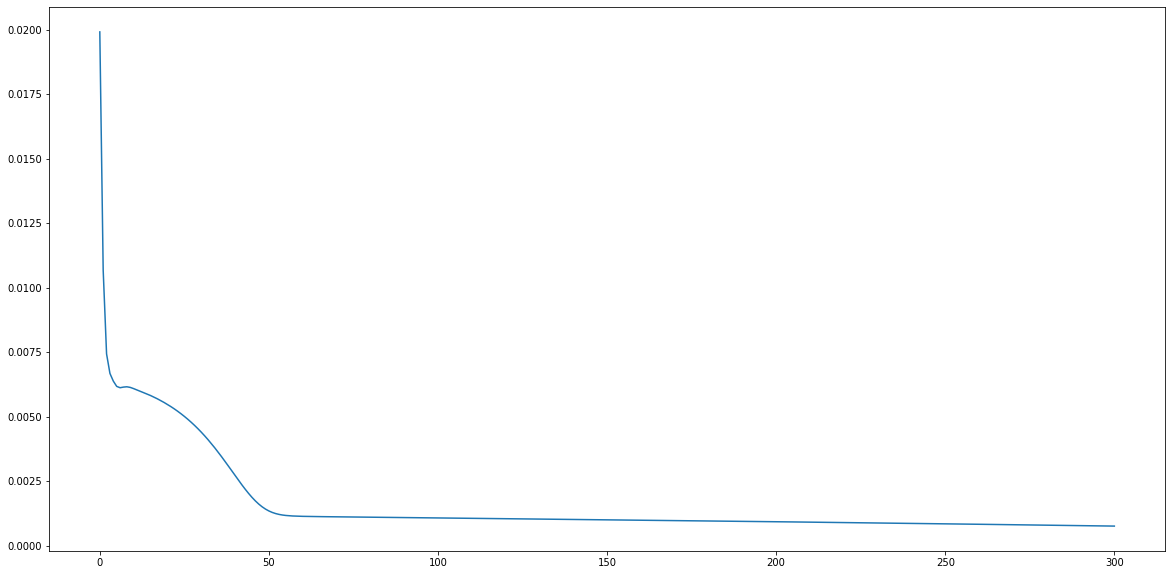

In [ ]:
# 학습 손실 함수값 그리기

plt.figure(figsize = (20,10))
plt.plot(loss_graph)
plt.show()

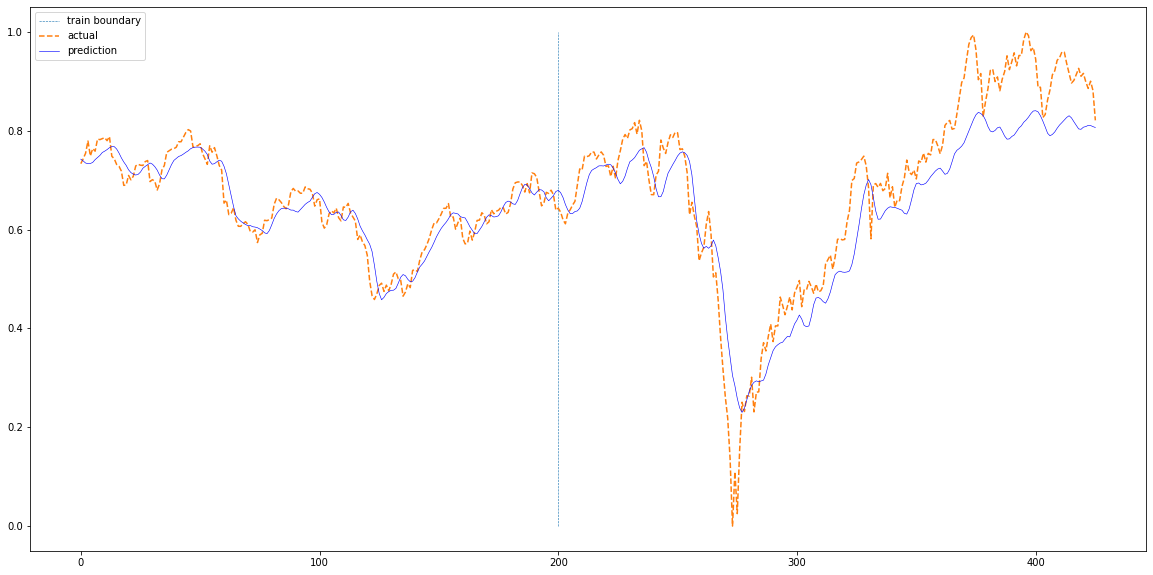

In [ ]:
# 주가 그리기

concatdata = torch.utils.data.ConcatDataset([train, test])
data_loader = torch.utils.data.DataLoader(dataset=concatdata, batch_size=100)

with torch.no_grad():
  pred=[]
  model.eval()
  for data in data_loader:
    seq, target = data
    out = model(seq)
    pred += out.cpu().tolist()

plt.figure(figsize=(20, 10))
plt.plot(np.ones(100)*len(train), np.linspace(0, 1, 100), '--', linewidth=0.6)
plt.plot(df['Close'][sequence_length:].values, '--')
plt.plot(pred, 'b', linewidth=0.6)
plt.legend(['train boundary', 'actual', 'prediction'])
plt.show()

# **7.2> LSTM과 GRU**

# **7.2.1) 기본 RNN의 문제**

-기울기 사라짐

-장기 의존성성

# **7.2.2) LSTM(Long Short-Term Memory)**

In [ ]:
#모델 구축하기

class LSTM(nn.Module):
    
    def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
        super(LSTM, self).__init__()
        self.device = device
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size*sequence_length, 1)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device) # <- cell state 추가
        out, _ = self.lstm(x, (h0, c0)) # output, (hn, cn): cell state와 hidden state만 반환
        out = out.reshape(out.shape[0], -1) # <- state 추가
        out = self.fc(out)
        return out

# **7.2.3) GRU(Gated Recurrent Units)**

In [ ]:
# 모델 구축하기

class GRU(nn.Module):
    
    def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
        super(GRU, self).__init__()
        self.device = device
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size*sequence_length, 1)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)
        out, _ = self.gru(x, h0)
        out = out.reshape(out.shape[0], -1) # <- state 추가
        out = self.fc(out)
        return out

# **7.3> Bi-LSTM**

# **7.3.1) Bi-LSTM 구현하기**

In [ ]:
# 라이브러리 불러오기

import torch
import torchvision
import torch.nn as nn 
import torch.optim as optim  
from torch.utils.data import DataLoader

In [ ]:
# MNIST 데이터 불러오기

# Load Data
tensor_mode = torchvision.transforms.ToTensor()
trainset = torchvision.datasets.MNIST(root="./data", train=True, transform=tensor_mode, download=True)
testset = torchvision.datasets.MNIST(root="./data", train=False, transform=tensor_mode, download=True)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=128, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
# Bi-LSTM 모델 구축하기

class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, seq_length, num_classes, device):
        super(BiLSTM, self).__init__()
        self.device = device
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.seq_length = seq_length
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        #self.fc = nn.Linear(hidden_size * 2, num_classes)
        self.fc = nn.Linear(seq_length*hidden_size * 2, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(self.device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(self.device)
        out, _ = self.lstm(x, (h0, c0))
        #out = self.fc(out[:, -1, :])
        out = out.reshape(-1,self.seq_length*self.hidden_size * 2)
        out = self.fc(out)
        return out

In [ ]:
# 하이퍼 파라미터 정의하기

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sequence_length = trainset.data.size(1)
input_size = trainset.data.size(2)
num_layers = 2
hidden_size = 12
num_classes = 10

In [ ]:
# 모델, 손실 함수, 최적화 기법 정의하기

model = BiLSTM(input_size, hidden_size, num_layers, sequence_length, num_classes, device)
model = model.to(device)   
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-3)

In [ ]:
# 모델 학습하기

for epoch in range(51):
    correct = 0
    total = 0
    for data in trainloader:
        optimizer.zero_grad()
        inputs, labels = data[0].to(device).squeeze(1), data[1].to(device)  
        outputs = model(inputs)
        loss = criterion(outputs, labels)        
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.detach(), 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('[%d] train acc: %.2f' %(epoch, 100*correct/total))     

[0] train acc: 91.37
[1] train acc: 97.42
[2] train acc: 98.15
[3] train acc: 98.48
[4] train acc: 98.75
[5] train acc: 98.92
[6] train acc: 98.98
[7] train acc: 99.06
[8] train acc: 99.17
[9] train acc: 99.29
[10] train acc: 99.22
[11] train acc: 99.40
[12] train acc: 99.43
[13] train acc: 99.42
[14] train acc: 99.53
[15] train acc: 99.51
[16] train acc: 99.50
[17] train acc: 99.59
[18] train acc: 99.64
[19] train acc: 99.59
[20] train acc: 99.56
[21] train acc: 99.59
[22] train acc: 99.71
[23] train acc: 99.66
[24] train acc: 99.74
[25] train acc: 99.65
[26] train acc: 99.67
[27] train acc: 99.74
[28] train acc: 99.68
[29] train acc: 99.75
[30] train acc: 99.83
[31] train acc: 99.78
[32] train acc: 99.70
[33] train acc: 99.76
[34] train acc: 99.77
[35] train acc: 99.81
[36] train acc: 99.74
[37] train acc: 99.69
[38] train acc: 99.88
[39] train acc: 99.86
[40] train acc: 99.63
[41] train acc: 99.68
[42] train acc: 99.78
[43] train acc: 99.86
[44] train acc: 99.92
[45] train acc: 99.6

In [ ]:
# 모델 평가하기

def accuracy(dataloader):
    correct = 0
    total = 0
    with torch.no_grad():
        model.eval()
        for data in dataloader:
            inputs, labels = data[0].to(device).squeeze(1), data[1].to(device)      
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)      
            correct += (predicted == labels).sum().item()

    acc = 100*correct/total
    model.train()
    return acc

In [ ]:
train_acc = accuracy(trainloader)
test_acc = accuracy(testloader)
print("Train Acc: %.1f, Test Acc: %.1f" %(train_acc, test_acc))

Train Acc: 99.8, Test Acc: 98.6
